In [ ]:
# 🔧 Стандартные библиотеки Python
import os
import json

# 📊 Работа с таблицами и массивами
import numpy as np
import pandas as pd

# 🧠 PyTorch
import torch
import torch.nn as nn

# 📈 Визуализация
import matplotlib.pyplot as plt

# 📏 Метрики качества
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


In [5]:
# ➤ Класс CNN-модели
class WindPressureCNN(nn.Module):
    def __init__(self, input_channels, filters, activation_fn, use_batchnorm):
        super(WindPressureCNN, self).__init__()

        layers = []
        in_channels = input_channels
        for out_channels in filters:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            if use_batchnorm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(activation_fn())
            in_channels = out_channels

        self.encoder = nn.Sequential(*layers)

        self.decoder = nn.Sequential(
            nn.Conv2d(filters[-1], filters[-2], kernel_size=3, padding=1),
            activation_fn(),
            nn.Conv2d(filters[-2], 1, kernel_size=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [6]:
# ➤ Класс CNN-модели (предполагаем, что он уже определён выше)
# class WindPressureCNN(nn.Module): ...

# 📍 Укажи путь к конфигу и весам
CONFIG_PATH = "/mnt/d/projects/wind_pressure_prediction_CNN/final_models/cnn_2e-04lr_64bs_ELU_16f_best/cnn_2e-04lr_64bs_ELU_16f.json"
MODEL_SAVE_PATH = "/mnt/d/projects/wind_pressure_prediction_CNN/final_models/cnn_2e-04lr_64bs_ELU_16f_best/best_input_seed159646_ELU_Adam.pth"

# ➤ Загружаем конфиг
with open(CONFIG_PATH, "r") as f:
    config = json.load(f)

# ➤ Преобразуем имя функции активации в класс
activation_map = {
    "ReLU": nn.ReLU,
    "Tanh": nn.Tanh,
    "Sigmoid": nn.Sigmoid,
    "LeakyReLU": nn.LeakyReLU,
    "ELU": nn.ELU,
    "SELU": nn.SELU,
    "GELU": nn.GELU
}


activation_fn = activation_map[config["activation_fn"]]

# ➤ Воссоздаём модель
model = WindPressureCNN(
    input_channels=config["input_channels"],
    filters=config["filters"],
    activation_fn=activation_fn,
    use_batchnorm=config["batchnorm"]
)

# ✅ ЗАГРУЖАЕМ ВЕСА НА CPU
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=torch.device('cpu')))
model.eval()  # переводим в режим оценки

print("✅ Модель успешно восстановлена и готова к использованию.")


✅ Модель успешно восстановлена и готова к использованию.


In [ ]:
# 📥 Загрузка holdout-гридов
X_holdout = np.load("/mnt/d/projects/wind_pressure_prediction_CNN/data/holdout/cnn_input_case_id/X_cnn_case_id_ho.npy")

# 🔮 Предсказание
model.eval()
with torch.no_grad():
    X_tensor = torch.tensor(X_holdout, dtype=torch.float32)
    y_pred = model(X_tensor).numpy()  # → (N, 1, 9, 28)

# 💾 Сохраняем предсказания
np.save("/mnt/d/projects/wind_pressure_prediction_CNN/final_models/cnn_2e-04lr_64bs_ELU_16f_best/y_pred_case_id_ho.npy", y_pred)

print("✅ Предсказания успешно получены и сохранены.")
print("🧱 Y_pred shape:", y_pred.shape)


✅ Предсказания успешно получены и сохранены.
🧱 Y_pred shape: (122, 1, 9, 28)


График сохранён по пути:
/mnt/d/projects/wind_pressure_prediction_CNN/final_models/cnn_2e-04lr_64bs_ELU_16f_best/holdout_evaluation.png
Метрики сохранены по пути:
/mnt/d/projects/wind_pressure_prediction_CNN/final_models/cnn_2e-04lr_64bs_ELU_16f_best/holdout_metrics.json

📊 Holdout Evaluation Summary:
🔢 Total Points: 30744
✅ R²   = 0.9859
✅ MAE  = 0.0353
✅ MSE  = 0.003202


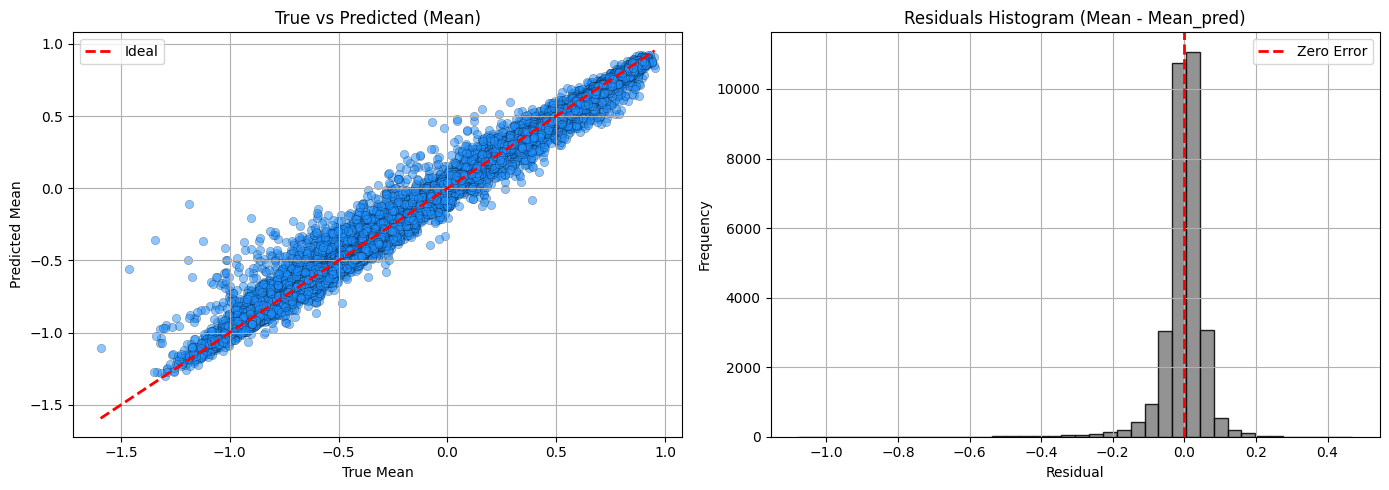

In [ ]:
# 📥 Загрузка тензоров
Y_true_tensor = np.load("/mnt/d/projects/wind_pressure_prediction_CNN/data/holdout/cnn_input_case_id/Y_cnn_case_id_ho.npy")
Y_pred_tensor = np.load("/mnt/d/projects/wind_pressure_prediction_CNN/final_models/cnn_2e-04lr_64bs_ELU_16f_best/y_pred_case_id_ho.npy")

# 🎯 Преобразуем в вектор
y_true = Y_true_tensor.reshape(-1)
y_pred = Y_pred_tensor.reshape(-1)
residuals = y_true - y_pred

# 📊 Метрики
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
num_points = len(y_true)

metrics = {
    "R2": round(r2, 4),
    "MAE": round(mae, 4),
    "MSE": round(mse, 6),
    "Total_Points": num_points
}

# 📁 Папка для сохранения
save_dir = "/mnt/d/projects/wind_pressure_prediction_CNN/final_models/cnn_2e-04lr_64bs_ELU_16f_best"
os.makedirs(save_dir, exist_ok=True)

# 📈 Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 🎯 True vs Predicted
axes[0].scatter(y_true, y_pred, alpha=0.5, color="dodgerblue", edgecolors='k', linewidths=0.3)
axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label="Ideal")
axes[0].set_xlabel("True Mean")
axes[0].set_ylabel("Predicted Mean")
axes[0].set_title("True vs Predicted (Mean)")
axes[0].grid(True)
axes[0].legend()

# 📊 Residuals Histogram
axes[1].hist(residuals, bins=40, color='gray', edgecolor='black', alpha=0.85)
axes[1].axvline(x=0, color='red', linestyle='--', lw=2, label="Zero Error")
axes[1].set_xlabel("Residual")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Residuals Histogram (Mean - Mean_pred)")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()

# 💾 Сохраняем график
plot_path = os.path.join(save_dir, "holdout_evaluation.png")
plt.savefig(plot_path, dpi=300)
print(f"График сохранён по пути:\n{plot_path}")

# 💾 Сохраняем метрики в JSON
metrics_path = os.path.join(save_dir, "holdout_metrics.json")
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=4)
print(f"Метрики сохранены по пути:\n{metrics_path}")

# 🖨 Печать метрик
print("\n📊 Holdout Evaluation Summary:")
print(f"🔢 Total Points: {metrics['Total_Points']}")
print(f"✅ R²   = {metrics['R2']}")
print(f"✅ MAE  = {metrics['MAE']}")
print(f"✅ MSE  = {metrics['MSE']}")

